# Лабораторная работа № 5
## Часть 2
### Выполнили: Артамонв Д., Зарубина М., Железцова И., Контаев И. 16ПМИ

In [1]:
import sys
import os
import re
import json
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim
from ufal.udpipe import Model, Pipeline

import torch

Загрузим текстовые данные

In [2]:
with open("data/nplus1_news.json") as f:
    corpus = json.load(f)

In [3]:
texts = list()
categories = list()
for sample in corpus:
    texts.append(sample['text'])
    categories.append(sample['category'])
    
assert len(texts) == len(categories)

df = pd.DataFrame({'text':texts, 'category': categories})
df.head()

,text,category
0,Ученые сделали обширный обзор макроскопических...,Медицина
1,"Эволюционные биологи выдвинули новую гипотезу,...",Биология
2,Астрономы зафиксировали\nрадиоизлучение в прос...,Астрономия
3,"Шведские ученые выяснили, что уровень гормона ...",Психология
4,Швейцарские ученые создали полимерный материал...,Материалы


Выберем из корпуса топ-10 наиболее популярных категорий

In [4]:
categories_distribution = df.category.value_counts()
filtered_categories = set(categories_distribution[categories_distribution > 70].index)
df = df[df.category.isin(filtered_categories)]

In [5]:
print(f"Corpus size: {len(df)}")
df.category.value_counts()

Corpus size: 1553


Биология          267
Оружие            244
Астрономия        207
Медицина          172
Физика            166
Космонавтика      123
IT                108
Роботы и дроны    104
Археология         91
Авиация            71
Name: category, dtype: int64

In [6]:
'''
Этот скрипт принимает на вход необработанный русский текст 
(одно предложение на строку или один абзац на строку).
Он токенизируется, лемматизируется и размечается по частям речи с использованием UDPipe.
На выход подаётся последовательность разделенных пробелами лемм с частями речи 
("зеленый_NOUN трамвай_NOUN").
Их можно непосредственно использовать в моделях с RusVectōrēs (https://rusvectores.org).
Примеры запуска:
echo 'Мама мыла раму.' | python3 rus_preprocessing_udpipe.py
zcat large_corpus.txt.gz | python3 rus_preprocessing_udpipe.py | gzip > processed_corpus.txt.gz
'''


def num_replace(word):
    newtoken = 'x' * len(word)
    return newtoken


def clean_token(token, misc):
    """
    :param token:  токен (строка)
    :param misc:  содержимое поля "MISC" в CONLLU (строка)
    :return: очищенный токен (строка)
    """
    out_token = token.strip().replace(' ', '')
    if token == 'Файл' and 'SpaceAfter=No' in misc:
        return None
    return out_token


def clean_lemma(lemma, pos):
    """
    :param lemma: лемма (строка)
    :param pos: часть речи (строка)
    :return: очищенная лемма (строка)
    """
    out_lemma = lemma.strip().replace(' ', '').replace('_', '').lower()
    if '|' in out_lemma or out_lemma.endswith('.jpg') or out_lemma.endswith('.png'):
        return None
    if pos != 'PUNCT':
        if out_lemma.startswith('«') or out_lemma.startswith('»'):
            out_lemma = ''.join(out_lemma[1:])
        if out_lemma.endswith('«') or out_lemma.endswith('»'):
            out_lemma = ''.join(out_lemma[:-1])
        if out_lemma.endswith('!') or out_lemma.endswith('?') or out_lemma.endswith(',') \
                or out_lemma.endswith('.'):
            out_lemma = ''.join(out_lemma[:-1])
    return out_lemma


def list_replace(search, replacement, text):
    search = [el for el in search if el in text]
    for c in search:
        text = text.replace(c, replacement)
    return text


def unify_sym(text):  # принимает строку в юникоде
    text = list_replace \
        ('\u00AB\u00BB\u2039\u203A\u201E\u201A\u201C\u201F\u2018\u201B\u201D\u2019', '\u0022', text)

    text = list_replace \
        ('\u2012\u2013\u2014\u2015\u203E\u0305\u00AF', '\u2003\u002D\u002D\u2003', text)

    text = list_replace('\u2010\u2011', '\u002D', text)

    text = list_replace \
            (
            '\u2000\u2001\u2002\u2004\u2005\u2006\u2007\u2008\u2009\u200A\u200B\u202F\u205F\u2060\u3000',
            '\u2002', text)

    text = re.sub('\u2003\u2003', '\u2003', text)
    text = re.sub('\t\t', '\t', text)

    text = list_replace \
            (
            '\u02CC\u0307\u0323\u2022\u2023\u2043\u204C\u204D\u2219\u25E6\u00B7\u00D7\u22C5\u2219\u2062',
            '.', text)

    text = list_replace('\u2217', '\u002A', text)

    text = list_replace('…', '...', text)

    text = list_replace('\u2241\u224B\u2E2F\u0483', '\u223D', text)

    text = list_replace('\u00C4', 'A', text)  # латинская
    text = list_replace('\u00E4', 'a', text)
    text = list_replace('\u00CB', 'E', text)
    text = list_replace('\u00EB', 'e', text)
    text = list_replace('\u1E26', 'H', text)
    text = list_replace('\u1E27', 'h', text)
    text = list_replace('\u00CF', 'I', text)
    text = list_replace('\u00EF', 'i', text)
    text = list_replace('\u00D6', 'O', text)
    text = list_replace('\u00F6', 'o', text)
    text = list_replace('\u00DC', 'U', text)
    text = list_replace('\u00FC', 'u', text)
    text = list_replace('\u0178', 'Y', text)
    text = list_replace('\u00FF', 'y', text)
    text = list_replace('\u00DF', 's', text)
    text = list_replace('\u1E9E', 'S', text)

    currencies = list \
            (
            '\u20BD\u0024\u00A3\u20A4\u20AC\u20AA\u2133\u20BE\u00A2\u058F\u0BF9\u20BC\u20A1\u20A0\u20B4\u20A7\u20B0\u20BF\u20A3\u060B\u0E3F\u20A9\u20B4\u20B2\u0192\u20AB\u00A5\u20AD\u20A1\u20BA\u20A6\u20B1\uFDFC\u17DB\u20B9\u20A8\u20B5\u09F3\u20B8\u20AE\u0192'
        )

    alphabet = list \
            (
            '\t\n\r абвгдеёзжийклмнопрстуфхцчшщьыъэюяАБВГДЕЁЗЖИЙКЛМНОПРСТУФХЦЧШЩЬЫЪЭЮЯ,.[]{}()=+-−*&^%$#@!~;:0123456789§/\|"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ ')

    alphabet.append("'")

    allowed = set(currencies + alphabet)

    cleaned_text = [sym for sym in text if sym in allowed]
    cleaned_text = ''.join(cleaned_text)

    return cleaned_text


def process(pipeline, text='Строка', keep_pos=True, keep_punct=False):
    # Если частеречные тэги не нужны (например, их нет в модели), выставьте pos=False
    # в этом случае на выход будут поданы только леммы
    # По умолчанию знаки пунктуации вырезаются. Чтобы сохранить их, выставьте punct=True

    entities = {'PROPN'}
    named = False
    memory = []
    mem_case = None
    mem_number = None
    tagged_propn = []

    # обрабатываем текст, получаем результат в формате conllu:
    processed = pipeline.process(text)

    # пропускаем строки со служебной информацией:
    content = [l for l in processed.split('\n') if not l.startswith('#')]

    # извлекаем из обработанного текста леммы, тэги и морфологические характеристики
    tagged = [w.split('\t') for w in content if w]

    for t in tagged:
        if len(t) != 10:
            continue
        (word_id, token, lemma, pos, xpos, feats, head, deprel, deps, misc) = t
        token = clean_token(token, misc)
        lemma = clean_lemma(lemma, pos)
        if not lemma or not token:
            continue
        if pos in entities:
            if '|' not in feats:
                tagged_propn.append('%s_%s' % (lemma, pos))
                continue
            morph = {el.split('=')[0]: el.split('=')[1] for el in feats.split('|')}
            if 'Case' not in morph or 'Number' not in morph:
                tagged_propn.append('%s_%s' % (lemma, pos))
                continue
            if not named:
                named = True
                mem_case = morph['Case']
                mem_number = morph['Number']
            if morph['Case'] == mem_case and morph['Number'] == mem_number:
                memory.append(lemma)
                if 'SpacesAfter=\\n' in misc or 'SpacesAfter=\s\\n' in misc:
                    named = False
                    past_lemma = '::'.join(memory)
                    memory = []
                    tagged_propn.append(past_lemma + '_PROPN')
            else:
                named = False
                past_lemma = '::'.join(memory)
                memory = []
                tagged_propn.append(past_lemma + '_PROPN')
                tagged_propn.append('%s_%s' % (lemma, pos))
        else:
            if not named:
                if pos == 'NUM' and token.isdigit():  # Заменяем числа на xxxxx той же длины
                    lemma = num_replace(token)
                tagged_propn.append('%s_%s' % (lemma, pos))
            else:
                named = False
                past_lemma = '::'.join(memory)
                memory = []
                tagged_propn.append(past_lemma + '_PROPN')
                tagged_propn.append('%s_%s' % (lemma, pos))

    if not keep_punct:
        tagged_propn = [word for word in tagged_propn if word.split('_')[1] != 'PUNCT']
    if not keep_pos:
        tagged_propn = [word.split('_')[0] for word in tagged_propn]
    return tagged_propn


print('\nLoading the model...', file=sys.stderr)
udpipe_filename = "model/udpipe_syntagrus.model"
model = Model.load(udpipe_filename)
process_pipeline = Pipeline(model, 'tokenize', Pipeline.DEFAULT, Pipeline.DEFAULT, 'conllu')


Loading the model...


Выполним предоработку текста чтобы получить токены с частеречной разметкой в соответсвии с преобученной моделью word2vec

In [7]:
tokens = list()

for text in df.text:
    output = process(process_pipeline, text=unify_sym(text), keep_pos=True)
    tokens.append(output)
    
df = df.assign(tokens=tokens)

labels, label_to_category = df.category.factorize()
df = df.assign(labels=labels)
df = df.reset_index()
df

,index,text,category,tokens,labels
0,0,Ученые сделали обширный обзор макроскопических...,Медицина,"[ученый_PROPN, делать_VERB, обширный_ADJ, обзо...",0
1,1,"Эволюционные биологи выдвинули новую гипотезу,...",Биология,"[эволюционный_ADJ, биолог_NOUN, выдвигать_VERB...",1
2,2,Астрономы зафиксировали\nрадиоизлучение в прос...,Астрономия,"[астроном_NOUN, фиксировать_VERB, радиоизлучен...",2
3,6,Астрономы подтвердили\r\nтепловую природу рент...,Астрономия,"[астроном_NOUN, подтверждать_VERB, тепловой_AD...",2
4,7,Американские инженеры разработали систему авто...,Роботы и дроны,"[американский_ADJ, инженер_NOUN, разрабатывать...",3
...,...,...,...,...,...
1548,2000,"Китайские разработчики создали алгоритм, спосо...",IT,"[китайский_ADJ, разработчик_NOUN, создавать_VE...",7
1549,2002,Ученые предложили использовать вакцину от грип...,Медицина,"[ученый_PROPN, предлагать_VERB, использовать_V...",0
1550,2003,30 декабря 2019 года умер авиаконструктор Вале...,Оружие,"[xx_NUM, декабрь_NOUN, xxxx_NUM, год_NOUN, уми...",8
1551,2005,Командование Армии США намерено до конца 2020 ...,Оружие,"[командование_NOUN, армия_PROPN, сша_PROPN, на...",8


Подготовим Dataset. Чтобы получить для каждого документа вектор признаков, возьмем среднее из эмбеддингов всех токенов в документе.

In [8]:
import torch
from torch.utils.data import Dataset

class NewsDataset(Dataset):
    def __init__(self, corpus):

        self.model = gensim.models.KeyedVectors.load_word2vec_format("model/word2vec/model.bin", binary=True)
        self.tokens = corpus.tokens
        self.labels = corpus.labels
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]

        embeddings = list()
        for t in self.tokens[idx]:
            try:
                embeddings.append(self.model[t])
            except KeyError:
                embeddings.append(np.zeros(300))

        doc_embedding = np.zeros(300)
        for embedding in embeddings:
            doc_embedding += embedding
        doc_embedding / len(doc_embedding)
        
        return doc_embedding, label

Обучим две модели: Dense и LSTM. Подберем гиперпараметры на валидации.

In [9]:
import torch.nn as nn

class Dense(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Dense, self).__init__()        
        self.classifier = nn.Sequential(nn.Linear(input_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, output_size))
        
    def forward(self, x):
        x = self.classifier(x)
        return x
    

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM, self).__init__()        
        self.model = nn.LSTM(input_size, hidden_size, num_layers)
        self.classifier =  nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x, hidden = self.model(x)
        x = self.classifier(x)
        return x

In [10]:
from torch.utils.data import DataLoader
from sklearn.metrics import recall_score, precision_score

def train(train_data):
    train_loss = 0
    train_acc = 0
    train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    for i, (text, label) in enumerate(train_data_loader):
        optimizer.zero_grad()
        text, label = text.to(device), label.to(device)
        text = text.unsqueeze(1)
        output = model(text.float())
        output = output.squeeze(1)
        loss = criterion(output, label)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_acc += (output.argmax(1) == label).sum().item()
    return train_loss / len(train_data), train_acc / len(train_data)

def test(model, test_data):
    loss = 0
    acc = 0
    precisions = list()
    recalls = list()
    test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE)
    for text, label in test_data_loader:
        text, label = text.to(device), label.to(device)
        with torch.no_grad():
            text = text.unsqueeze(1)
            output = model(text.float())
            output = output.squeeze(1)
            acc += (output.argmax(1) == label).sum().item()
            precisions.append(precision_score(output.argmax(1).cpu().numpy(), label.cpu().numpy(), average='macro'))
            recalls.append(recall_score(output.argmax(1).cpu().numpy(), label.cpu().numpy(), average='macro'))
    return acc / len(test_data), sum(precisions) / len(precisions), sum(recalls) / len(recalls)

def train_loop(model, train_data, test_data):
    best_model = None
    best_valid_acc = 0
    for epoch in range(N_EPOCHS):

        start_time = time.time()
        train_loss, train_acc = train(train_data)
        valid_acc, precision, recall = test(model, test_data)

        secs = int(time.time() - start_time)
        mins = secs / 60
        secs = secs % 60

        print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
        print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
        print(f'\tAcc: {valid_acc * 100:.1f}%(valid)\t|\tPrecision: {precision * 100:.1f}%(valid)\t|\tRecall: {recall * 100:.1f}%(valid)')        
        
        if best_valid_acc < valid_acc:
            best_model = model
    
    return best_model

In [11]:
import time
from tqdm import tqdm
from torch.utils.data.dataset import random_split

N_EPOCHS = 20
BATCH_SIZE = 32
device = 'cuda'

criterion = torch.nn.CrossEntropyLoss().to(device)

news_dataset = NewsDataset(df)

train_len = int(len(news_dataset) * 0.8)
val_len = int(train_len * 0.1)
test_len = len(news_dataset) - train_len - val_len

print(f"train: {train_len}")
print(f"val: {val_len}")
print(f"test: {test_len}")
train_data, val_data, test_data = random_split(news_dataset, [train_len, val_len, test_len])

train: 1242
val: 124
test: 187


In [12]:
input_size = 300
output_size = 10
hidden_size = 64

model = Dense(input_size, hidden_size, output_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
print(model)
best_dense = train_loop(model, train_data, val_data)
test_acc, test_precision, test_recall = test(best_dense, test_data)

print(f"test accuracy:{test_acc:.4f}")
print(f"test precision:{test_precision:.4f}")
print(f"test recall:{test_recall:.4f}")

Dense(
  (classifier): Sequential(
    (0): Linear(in_features=300, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)


/home/ideis/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1  | time in 0 minutes, 2 seconds
	Loss: 0.1286(train)	|	Acc: 46.7%(train)
	Acc: 71.0%(valid)	|	Precision: 66.0%(valid)	|	Recall: 58.9%(valid)


/home/ideis/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2  | time in 0 minutes, 2 seconds
	Loss: 0.0232(train)	|	Acc: 75.4%(train)
	Acc: 77.4%(valid)	|	Precision: 72.5%(valid)	|	Recall: 70.3%(valid)
Epoch: 3  | time in 0 minutes, 2 seconds
	Loss: 0.0184(train)	|	Acc: 79.7%(train)
	Acc: 83.1%(valid)	|	Precision: 83.1%(valid)	|	Recall: 82.5%(valid)
Epoch: 4  | time in 0 minutes, 2 seconds
	Loss: 0.0165(train)	|	Acc: 81.6%(train)
	Acc: 68.5%(valid)	|	Precision: 66.7%(valid)	|	Recall: 69.1%(valid)
Epoch: 5  | time in 0 minutes, 2 seconds
	Loss: 0.0149(train)	|	Acc: 83.7%(train)
	Acc: 75.0%(valid)	|	Precision: 72.9%(valid)	|	Recall: 72.0%(valid)
Epoch: 6  | time in 0 minutes, 2 seconds
	Loss: 0.0163(train)	|	Acc: 81.7%(train)
	Acc: 84.7%(valid)	|	Precision: 82.5%(valid)	|	Recall: 82.6%(valid)
Epoch: 7  | time in 0 minutes, 2 seconds
	Loss: 0.0126(train)	|	Acc: 85.5%(train)
	Acc: 87.1%(valid)	|	Precision: 84.9%(valid)	|	Recall: 84.2%(valid)
Epoch: 8  | time in 0 minutes, 2 seconds
	Loss: 0.0102(train)	|	Acc: 89.1%(train)
	Acc: 85.5%(valid)

In [16]:
input_size = 300
output_size = 10
hidden_size = 128
num_layers = 1

model = LSTM(input_size, hidden_size, output_size, num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)
best_lstm = train_loop(model, train_data, test_data)
test_acc, test_precision, test_recall = test(best_lstm, test_data)

print(f"test accuracy:{test_acc:.4f}")
print(f"test precision:{test_precision:.4f}")
print(f"test recall:{test_recall:.4f}")

LSTM(
  (model): LSTM(300, 128)
  (classifier): Linear(in_features=128, out_features=10, bias=True)
)
Epoch: 1  | time in 0 minutes, 2 seconds
	Loss: 0.0574(train)	|	Acc: 45.4%(train)
	Acc: 56.7%(valid)	|	Precision: 47.5%(valid)	|	Recall: 39.4%(valid)
Epoch: 2  | time in 0 minutes, 2 seconds
	Loss: 0.0420(train)	|	Acc: 65.3%(train)
	Acc: 69.0%(valid)	|	Precision: 61.2%(valid)	|	Recall: 61.8%(valid)
Epoch: 3  | time in 0 minutes, 2 seconds
	Loss: 0.0330(train)	|	Acc: 75.0%(train)
	Acc: 77.5%(valid)	|	Precision: 76.0%(valid)	|	Recall: 74.3%(valid)
Epoch: 4  | time in 0 minutes, 2 seconds
	Loss: 0.0269(train)	|	Acc: 80.3%(train)
	Acc: 76.5%(valid)	|	Precision: 73.3%(valid)	|	Recall: 72.3%(valid)
Epoch: 5  | time in 0 minutes, 2 seconds
	Loss: 0.0228(train)	|	Acc: 83.1%(train)
	Acc: 79.1%(valid)	|	Precision: 77.2%(valid)	|	Recall: 78.4%(valid)
Epoch: 6  | time in 0 minutes, 2 seconds
	Loss: 0.0202(train)	|	Acc: 84.2%(train)
	Acc: 77.5%(valid)	|	Precision: 75.8%(valid)	|	Recall: 73.6%(valid

Проанализируем отношение ошибки в категориях

In [17]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Contingency matrix'):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(12, 12))
    plt.title(title, fontsize=16)
    tick_marks = np.arange(cm.shape[0])
    classes =  label_to_category

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.xticks(tick_marks, classes, rotation=30, size=10)
    plt.yticks(tick_marks, classes, size=10)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.tight_layout()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    
def calculate_confusion_matrix(model, test_data):
    test_data_loader = DataLoader(test_data)
    preds = list()
    labels = list()

    for text, label in test_data_loader:
        text, label = text.to(device), label.to(device)
        with torch.no_grad():
            text = text.unsqueeze(1)
            output = model(text.float())
            output = output.squeeze(1)
            preds.append(output.argmax(1).item())
            labels.append(label.item())

    return confusion_matrix(labels, preds)

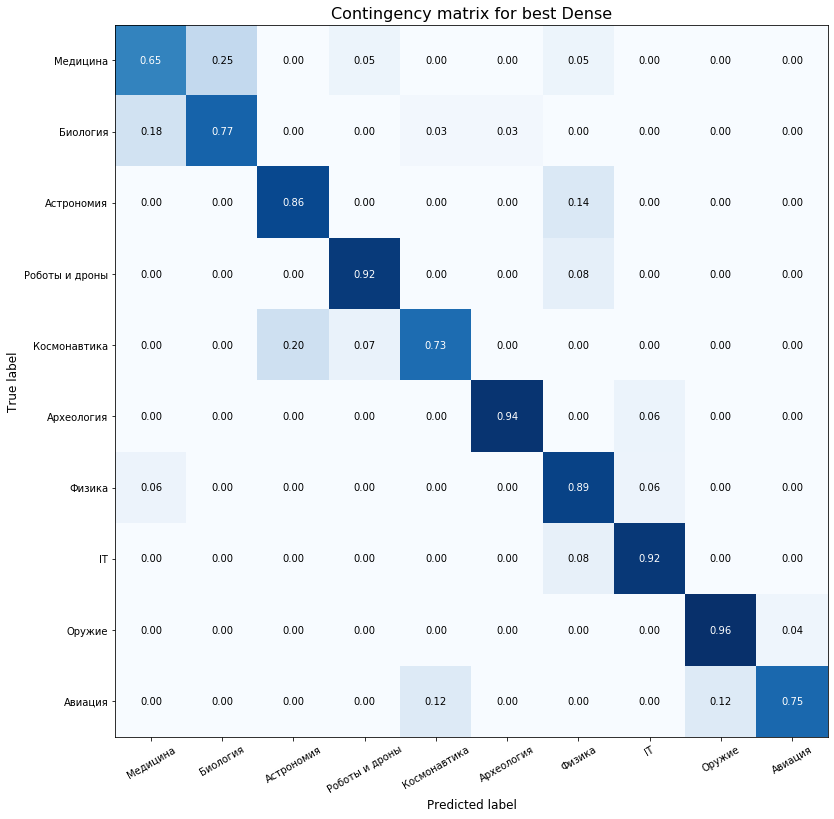

In [18]:
plot_confusion_matrix(calculate_confusion_matrix(best_dense, test_data), title="Contingency matrix for best Dense")

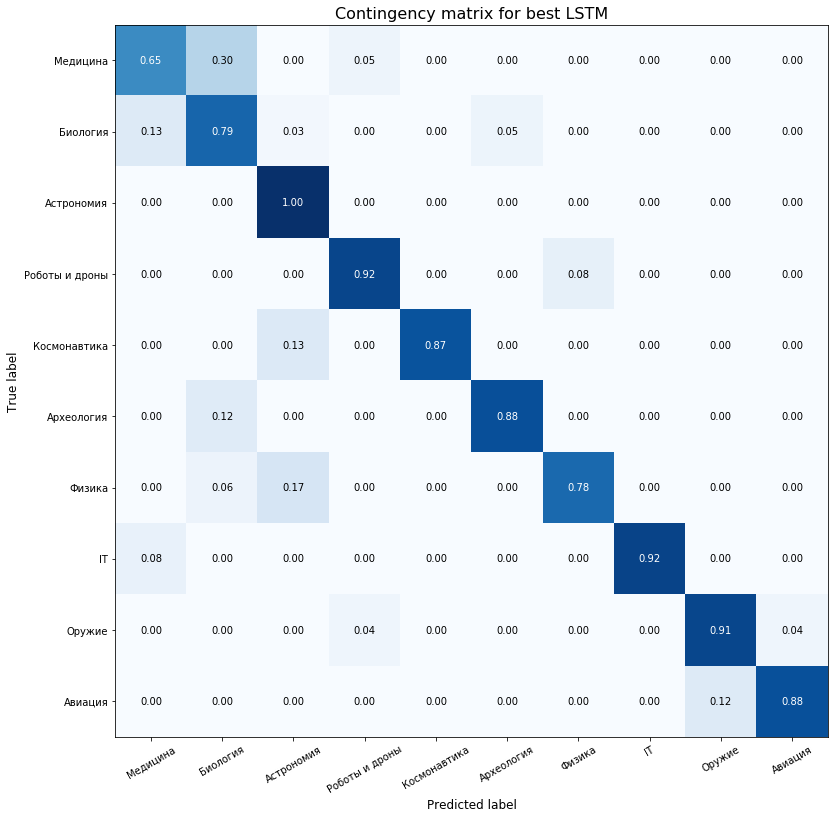

In [19]:
plot_confusion_matrix(calculate_confusion_matrix(best_lstm, test_data), title="Contingency matrix for best LSTM")

Обе модели ошибаются только между смежными категорями, напр. медицина и биология или физика и астрономия. Для такого количества данных качество моделей достойное, даже не смотря на усреднение эмб 